**Wesleyan University ASTR 210**

# Homework 4: SDSS galaxy catalog

In this homework, we will work with a catalog of galaxies from the Sloan Digital Sky Survey (SDSS), examine their properties, and classify them according to their star formation rate and stellar mass.  

Before continuing, make sure the file sdss_catalog.csv is your data folder.

## Import statements (5 points)

In this assignment, we will need to:
- Read a plaintext (ascii) data file into Table format
- Manipulate arrays
- Plot things
- Use a logarithmic normalization
- Calculate the normal probability density function

Import all the packages you will need accordingly.

In [4]:

import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from matplotlib.colors import LogNorm
from scipy.stats import norm

# YOUR CODE HERE

## Reading a CSV file into an astropy Table (6 points)

The data file we will be using is named sdss_catalog.csv, where CSV stands for "comma-separated values."  (You can look at the file and see why!)  CSV is another very common type of plaintext file format which can be easily read in as an astropy Table.

**(3 points)** Read in the data file and assign it to a variable named sdss_catalog. 

In [5]:
sdss_catalog = Table.read('../data/sdss_catalog.csv', format='csv')# YOUR CODE HERE

**(3 points)** Print the first 10 elements of the catalog.

In [6]:
print(sdss_catalog[:10])# YOUR CODE HERE

    log mstar            log sfr      
------------------ -------------------
10.308452606201172 -0.4944599270820617
11.176507949829102  0.1608800888061523
11.391095161437988  -0.760689914226532
11.608617782592772               -99.0
   9.9728364944458 -0.2997999191284179
 10.92574691772461 -0.8098399043083191
10.795482635498049 -0.3515599071979522
11.377850532531738 -0.5204799175262451
10.154738426208496  0.0813900977373123
11.177846908569336 -0.6051499247550964


You should see that your read() function has correctly interpreted the first line of the file as containing the names of each column, where the columns are:
- **log mstar**: The log (base 10) of total mass of the stars in the galaxy, in units of solar masses.
- **log sfr**: The log (base 10) of the star formation rate in the galaxy, in units of solar masses per year.

## Examine the data and mask missing values (22 points)

Let's take a look at what we've got, by plotting the two columns against each other.

**(4 points)** Make a scatter plot with log(Mstar) on the x-axis and log(SFR) on the y-axis.  Be sure to label your axes and include the units.

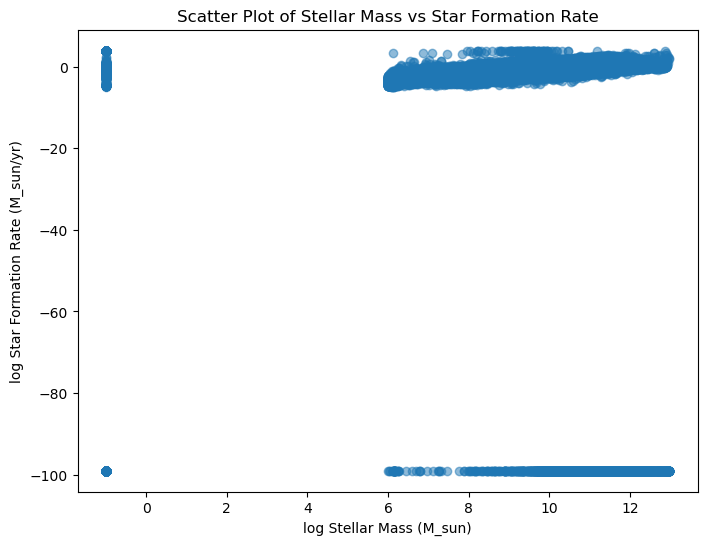

In [7]:
plt.figure(figsize=(8, 6))
plt.scatter(sdss_catalog['log mstar'], sdss_catalog['log sfr'], alpha=0.5)
plt.xlabel('log Stellar Mass (M_sun)')
plt.ylabel('log Star Formation Rate (M_sun/yr)')
plt.title('Scatter Plot of Stellar Mass vs Star Formation Rate')
plt.show()


Uh oh!  You should find that the real data is crowded up in the top right corner, with suspicious-looking lines on the left, bottom, and top of the plot.  These are "dummy" values that were assigned when the real value was missing.  (The dummy values appear in the file itself rather than being left blank, which is why they were not flagged as "missing" when the data was read in.)  We'll need to eliminate those entries when working with the data.

We will need to define our own Boolean **mask** that will select only the entries with real data values.

**(6 points)** Create a Boolean mask named has_all_values which is False for the points with dummy values (the ones in lines at the edges of the plot) and True otherwise.  

Hints:
- You should have three Boolean conditions in total: one for the bottom edge, one for the left edge, and one for the top edge.
- To check your work, continue to the next block and remake the plot with the mask applied.  You may need to iterate a couple of times to find the best threshold values.
- For the left side, you will find that there is a second pile-up of data points near log mstar = 6.  You should mask that out as well, because it is unphysical.  (That is, the pile-up represents a numerical / data quality issue rather than representing the true density of points in that region, so it should be excluded.)

In [8]:
# Create a Boolean mask to filter out dummy values
has_all_values = (sdss_catalog['log mstar'] > 7) & (sdss_catalog['log sfr'] > -4) & (sdss_catalog['log sfr'] < 3)


**(4 points)** Remake the scatter plot with the bad points masked out.

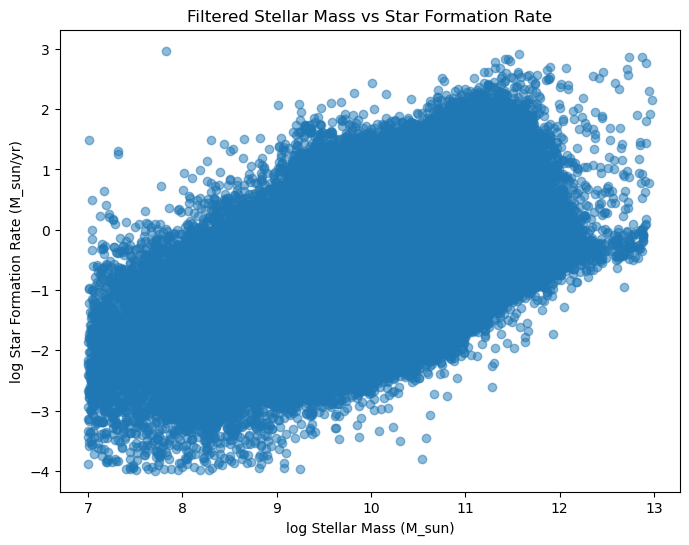

In [9]:
plt.figure(figsize=(8, 6))
plt.scatter(sdss_catalog['log mstar'][has_all_values], sdss_catalog['log sfr'][has_all_values], alpha=0.5)
plt.xlabel('log Stellar Mass (M_sun)')
plt.ylabel('log Star Formation Rate (M_sun/yr)')
plt.title('Filtered Stellar Mass vs Star Formation Rate')
plt.show()


Now that we have selected out the points with valid values only, we can see the overall shape of the relationship between stellar mass and star formation rate, but the center of the plot is completely saturated with points.  To see how the points are distributed within this area, we will need to use a 2d histogram.

**(8 points)** Remake the plot as a 2D histogram.  Your plot should:
- Use at least 150 bins in each direction,
- Use a logarithmic normalization for the color mapping, and
- Include a color bar
in addition to keeping the plotting guidelines I gave above regarding the axis labels.

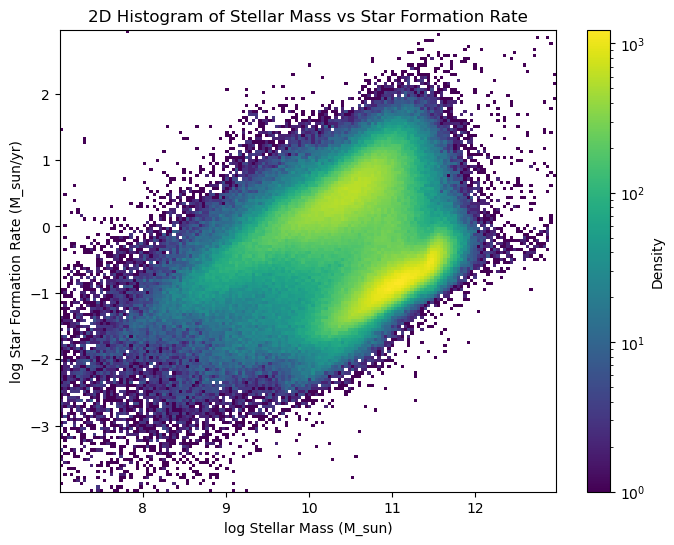

In [10]:
plt.figure(figsize=(8, 6))
plt.hist2d(sdss_catalog['log mstar'][has_all_values], sdss_catalog['log sfr'][has_all_values], bins=150, norm=LogNorm())
plt.colorbar(label='Density')
plt.xlabel('log Stellar Mass (M_sun)')
plt.ylabel('log Star Formation Rate (M_sun/yr)')
plt.title('2D Histogram of Stellar Mass vs Star Formation Rate')
plt.show()


Now we can see that there are two distinct clouds of points, running roughly parallel to one another.  The one on the top is the "star-forming sequence" of galaxies which are actively forming new stars (like the Milky Way), and the one on the bottom is a collection of "red and dead" galaxies with very little star formation.  Another word that we use to describe these galaxies is that their star formation is "quenched."  

## Define a boundary between star-forming and quenched galaxies (24 points)

In the remainder of the assignment, we will use the galaxies' position on the mass-SFR plane to separate them into two categories - star-forming and quenched - and compare the properties of these two populations.

To separate the two categories, we'll need to define a *Boolean condition* which describes whether a given galaxy lies in the upper or lower cloud of points.  Fortunately, from looking at the plot, it seems like we can effectively separate the two simply by drawing a straight line across the diagram.

**(6 points)** Find the slope and intercept of a line which separates the two clouds of points.  

Below, I have created an array of log Mstar values equally spaced from 6 to 13, and initialized variables for the slope and intercept of a line.

You should:
- Define a corresponding array logSFR which is linearly related to logMstar using that slope and intercept,
- Plot the line over top of the 2D histogram, and
- Play with the values of the slope and intercept until you have found a line that cleanly separates the two clouds.  (Note: there is not a single "right" answer here, there are many reasonable choices you can make.  There are *wrong* answers though!)

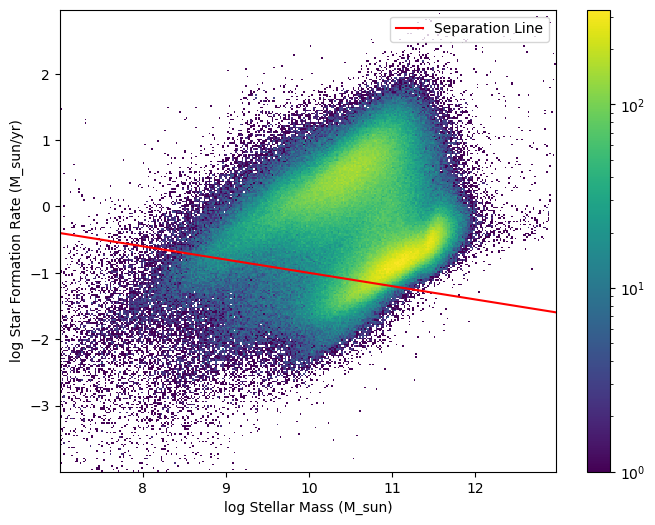

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.hist2d(sdss_catalog['log mstar'][has_all_values], sdss_catalog['log sfr'][has_all_values], bins=300, norm=LogNorm())
ax.set_xlabel('log Stellar Mass (M_sun)')
ax.set_ylabel('log Star Formation Rate (M_sun/yr)')
plt.colorbar()

# Define the line
slope = -0.2
intercept = 1.0
logMstar = np.linspace(6, 13, 100)
logSFR = slope * logMstar + intercept
plt.plot(logMstar, logSFR, color='red', label='Separation Line')
plt.legend(loc='upper right')
plt.show()



Now that we have found the expression for the separating line, we can use that information to create Boolean arrays that select galaxies in the star-forming and quenched categories.

**(8 points)** Define two Boolean arrays, starforming and quenched, which are True for galaxies which:
- starforming: lie *above* the line you defined above, **and** do not have any dummy values
- quenched: lie *below* the line you defined above, **and** do not have any dummy values

In [12]:
starforming = has_all_values & (sdss_catalog['log sfr'] > (slope * sdss_catalog['log mstar'] + intercept))
quenched = has_all_values & (sdss_catalog['log sfr'] <= (slope * sdss_catalog['log mstar'] + intercept))



If you have defined everything appropriately, the three categories of "star-forming", "quenched", and "have dummy values" should be mutually exclusive, and all entries in the catalog should belong to one of those three categories.  That means that the combined *sum* of the True values in those three Boolean arrays should be equal to the *length* of any one of them.

**(10 points)** Perform a sanity check to make sure your definitions are consistent.  Print out:
- The number of True values in the starforming array,
- The number of True values in the quenched array,
- The number of False values in the has_all_values array,
- The sum of the above, and
- The length of any of the above arrays, or the length of one of the columns in the catalog.

You should find that the last two numbers are identical.  If they are not, something has gone wrong and you should go back and check your work!  (Note that your first three numbers are likely to slightly differ from mine because we won't have exactly the same Boolean conditions - that's perfectly ok.)

In [13]:

print("Number of star-forming galaxies:", np.sum(starforming))
print("Number of quenched galaxies:", np.sum(quenched))
print("Number of bad values:", np.sum(~has_all_values))
print("Total galaxies:", len(sdss_catalog))


Number of star-forming galaxies: 725072
Number of quenched galaxies: 111586
Number of bad values: 90894
Total galaxies: 927552


## Examine the distributions within each category (27 points)

Now that we have separated our data into two categories (not including the "bad data" category), we can see how the distribution of properties varies between them.  

**(4 points)** To get a rough sense of how the two categories differ, print out the median log mstar and log sfr values in the star-forming and quenched categories.

In [14]:
median_starforming_mass = np.median(sdss_catalog['log mstar'][starforming])
median_starforming_sfr = np.median(sdss_catalog['log sfr'][starforming])
median_quenched_mass = np.median(sdss_catalog['log mstar'][quenched])
median_quenched_sfr = np.median(sdss_catalog['log sfr'][quenched])

print("Star-forming: Median Mass =", median_starforming_mass, ", Median SFR =", median_starforming_sfr)
print("Quenched: Median Mass =", median_quenched_mass, ", Median SFR =", median_quenched_sfr)
# YOUR CODE HERE

Star-forming: Median Mass = 10.776598930358888 , Median SFR = -0.16918491572141647
Quenched: Median Mass = 10.282802104949951 , Median SFR = -1.333549976348877


You should find that the typical star-forming galaxy has a *higher* SFR and a *lower* mass than the typical quenched galaxy.

Now let's take a closer look at the full distributions of these properties.

**(11 points)** Plot the distributions of log stellar mass and log SFR within each of the two categories.  Your plots should:
- Put the distributions for both categories on the same panel (but each quantity should have a different panel or plot),
- Not allow one distribution to obscure another behind it (that is, the histograms should be partially transparent or not filled in),
- Include a legend to indicate which distribution belongs to which category,
- Use probability density rather than raw count,
- Use an appropriate number of bins such that you can see the detailed shape but it's not noisy, 
- Use the same binning scheme for both distributions, and
- Have appropriately-labeled axes.

(Your plots do not need to look identical to mine, as long as you are following the guidelines above.)

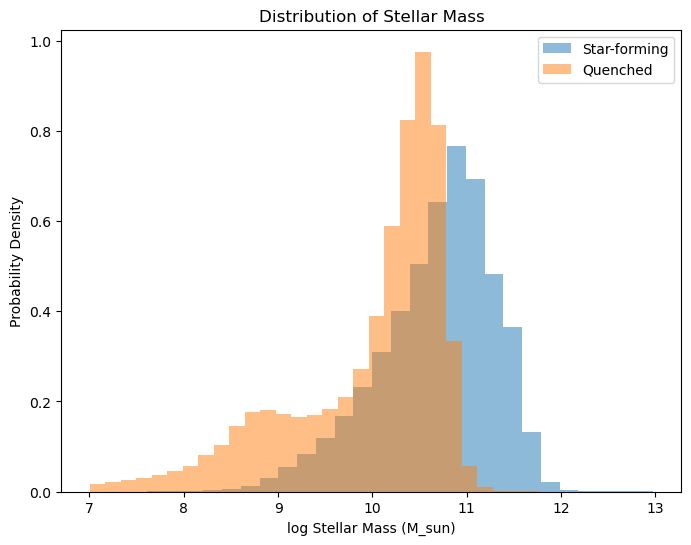

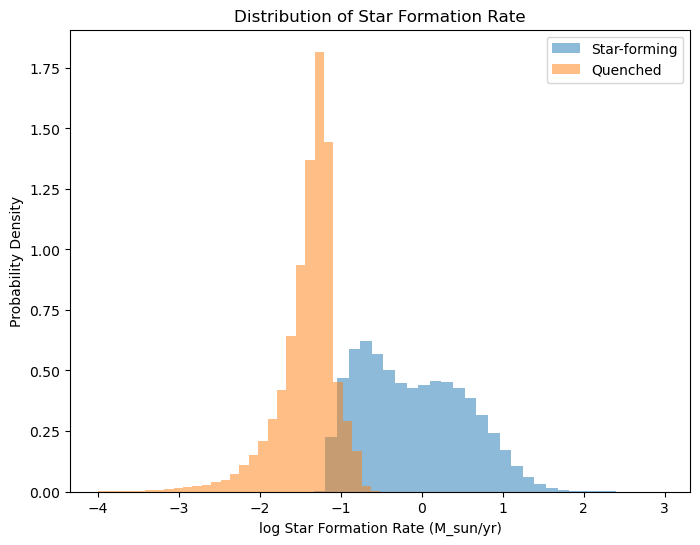

In [15]:
# Stellar mass distribution
plt.figure(figsize=(8, 6))
plt.hist(sdss_catalog['log mstar'][starforming], bins=30, density=True, alpha=0.5, label='Star-forming')
plt.hist(sdss_catalog['log mstar'][quenched], bins=30, density=True, alpha=0.5, label='Quenched')
plt.xlabel('log Stellar Mass (M_sun)')
plt.ylabel('Probability Density')
plt.legend()
plt.title('Distribution of Stellar Mass')
plt.show()

# SFR distribution
plt.figure(figsize=(8, 6))
plt.hist(sdss_catalog['log sfr'][starforming], bins=30, density=True, alpha=0.5, label='Star-forming')
plt.hist(sdss_catalog['log sfr'][quenched], bins=30, density=True, alpha=0.5, label='Quenched')
plt.xlabel('log Star Formation Rate (M_sun/yr)')
plt.ylabel('Probability Density')
plt.legend()
plt.title('Distribution of Star Formation Rate')
plt.show()
# YOUR CODE HERE

As in the Tutorial, these distributions look Gaussian-ish (if a bit skewed)!  Let's see what their Gaussian $\mu$ and $\sigma$ values would be, and overplot the corresponding normal distribution.

**(12 points)** For each distribution, **calculate and print** the mean and standard deviation, then **overplot the Gaussian** probability density functions with those parameters on top of your plot from above.

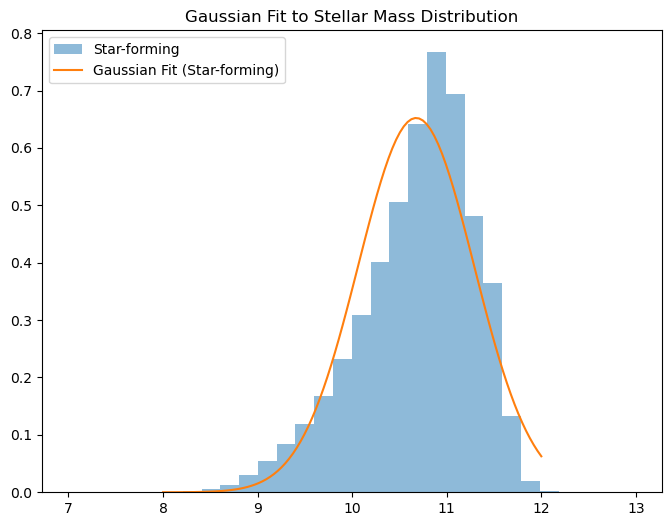

In [16]:
# Mean and std for star-forming mass
mean_starforming_mass = np.mean(sdss_catalog['log mstar'][starforming])
std_starforming_mass = np.std(sdss_catalog['log mstar'][starforming])
x = np.linspace(8, 12, 100)
pdf_starforming_mass = norm.pdf(x, mean_starforming_mass, std_starforming_mass)

# Overplot Gaussian for mass
plt.figure(figsize=(8, 6))
plt.hist(sdss_catalog['log mstar'][starforming], bins=30, density=True, alpha=0.5, label='Star-forming')
plt.plot(x, pdf_starforming_mass, label='Gaussian Fit (Star-forming)')
plt.legend()
plt.title('Gaussian Fit to Stellar Mass Distribution')
plt.show()
# YOUR CODE HERE

## Compute quenched fraction as a function of stellar mass (14 points)

When we compare the distributions of stellar mass in our two categories, we can see that higher-mass galaxies are more likely to be quenched, while lower-mass galaxies are more likely to be star-forming.  The *quenched fraction* $f_{\rm quenched}(M_*)$ describes the probability of a galaxy being quenched given its stellar mass:
$$f_{\rm quenched} = \frac{N_{\rm quenched}}{N_{\rm quenched}+N_{\rm star-forming}}$$

This is actually quite a straightforward quantity for us to calculate as a function of stellar mass from the histograms.  Because the histograms give us the number $N$ of star-forming and quenched galaxies in bins of stellar mass, all we have to do to compute $f_{\rm quenched}$ is plug the histogram counts into the expression above.  The arrays will be combined elementwise to produce the quenched fraction at each mass.

**(6 points)** Use ```np.histogram()``` to calculate histograms of stellar mass for the star-forming and quenched populations, and save the counts and bin edges as variables.

In [17]:
counts_starforming, bins = np.histogram(sdss_catalog['log mstar'][starforming], bins=30)
counts_quenched, _ = np.histogram(sdss_catalog['log mstar'][quenched], bins=bins)
# YOUR CODE HERE

**(8 points)** Calculate and plot $f_{\rm quenched}$.  Don't forget to label your axes!  (Note: remember that the count in each bin corresponds to the center of that bin.  Review Tutorial 7 to see an example of how to calculate the bin centers.)

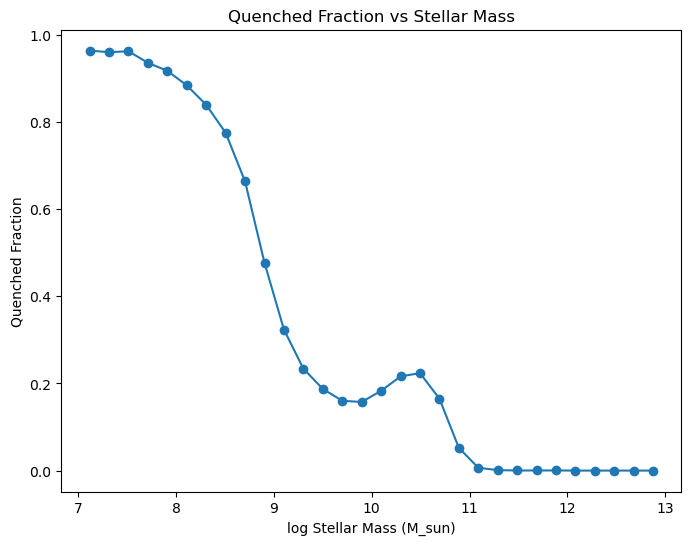

In [18]:
quenched_fraction = counts_quenched / (counts_starforming + counts_quenched)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

plt.figure(figsize=(8, 6))
plt.plot(bin_centers, quenched_fraction, marker='o')
plt.xlabel('log Stellar Mass (M_sun)')
plt.ylabel('Quenched Fraction')
plt.title('Quenched Fraction vs Stellar Mass')
plt.show()
# YOUR CODE HERE

This plot shows that there is a sharp transition around $M_* = 10^{10.7}$ M$_\odot$: below this mass, almost all galaxies are star-forming, but above it, most galaxies are quenched.  Believe it or not, the reason why is actually one of the major outstanding questions in galaxy formation theory!  (Come talk to me if you want to learn more - this is my research specialty.)  

**(2 points)** How difficult was this assignment on a scale of 1 to 5?  Were there any parts that were especially fun, frustrating, or unclear?

[YOUR RESPONSE HERE]

In [19]:
4

4